In [1]:
import json, os, numpy as np, tqdm, requests
from collections import defaultdict
from rdkit import Chem

### Trim all samples with no MS

In [2]:
with open("ALL_GNPS.json") as f:
    all_gnps = json.load(f)
del_list = []
for i in tqdm.tqdm(range(len(all_gnps))):
    if all_gnps[i]["peaks_json"] == "[]":
        del_list.append(i)
print("Data Len: ", len(all_gnps))
for i in reversed(del_list):
    del all_gnps[i]
print("Data Len after: ", len(all_gnps))


100%|██████████| 210569/210569 [00:00<00:00, 847365.48it/s]

Data Len:  210569
Data Len after:  209654


### Loading train/test data

In [1]:
data = {}
data["id"] = []
bad = [".DS_Store", ".ipynb_checkpoints"]
path = "./smart_data/train"
path2 = "./smart_data/train_aggregate"

done = False

for subdir in os.listdir(path):
    if "." not in subdir:
        data[subdir] = []
        subdirpath = os.path.join(path, subdir)
        for f in tqdm.tqdm(os.listdir(subdirpath)):
            if f not in bad:
                data[subdir].append(np.load(os.path.join(subdirpath, f)))
            if not done:
                data["id"].append(np.array(f))
        print(subdir)
        done = True

FileNotFoundError: [WinError 3] The system cannot find the path specified: './smart_data/train'

In [3]:
all_gnps[0]

{'spectrum_id': 'CCMSLIB00000001547',
 'source_file': '130618_Ger_Jenia_WT-3-Des-MCLR_MH981.4-qb.1.1..mgf',
 'task': '47daa4396adb426eaa5fa54b6ce7dd5f',
 'scan': '1',
 'ms_level': '2',
 'library_membership': 'GNPS-LIBRARY',
 'spectrum_status': '1',
 'peaks_json': '[[289.286377,8068.000000],[295.545288,22507.000000],[298.489624,3925.000000],[317.324951,18742.000000],[319.655945,8604.000000],[324.482422,8041.000000],[325.316284,9738.000000],[339.789429,16145.000000],[343.947021,18094.000000],[347.020508,13981.000000],[347.913391,6765.000000],[361.147705,11763.000000],[361.844360,24296.000000],[364.232727,2346.000000],[364.858154,10782.000000],[365.845886,10242.000000],[368.221680,12761.000000],[368.965698,19147.000000],[375.069519,15644.000000],[375.751953,25393.000000],[382.750549,12765.000000],[384.197083,17912.000000],[390.574219,7993.000000],[394.049194,16135.000000],[397.106262,13986.000000],[404.420715,12326.000000],[411.092712,2348.000000],[413.784546,8715.000000],[427.667358,6813

In [ ]:
list(data.keys())
stacked = {}

for key in data:
    print(key, type(data[key][0]), data[key][0].shape if type(data[key][0]) == np.ndarray else "")

for key in data:
    first = list(data[key][0].shape)
    stacked[key] = np.stack(data[key])

for k, v in stacked.items():
    np.save(os.path.join(path2, k + ".npy"),  v)


    


# GNPS Data Stats

In [ ]:
np.load("./smart_data/singular_specs/meta/ids.npy")

array(['CCMSLIB00000001547', 'CCMSLIB00000001548', 'CCMSLIB00000001549',
       ..., 'CCMSLIB00005724257', 'CCMSLIB00005724258',
       'CCMSLIB00005724259'], dtype='<U18')

In [3]:
print(len(all_gnps))
[t for t in all_gnps if t["spectrum_id"] == "CCMSLIB00000001547"]

209654


[{'spectrum_id': 'CCMSLIB00000001547',
  'source_file': '130618_Ger_Jenia_WT-3-Des-MCLR_MH981.4-qb.1.1..mgf',
  'task': '47daa4396adb426eaa5fa54b6ce7dd5f',
  'scan': '1',
  'ms_level': '2',
  'library_membership': 'GNPS-LIBRARY',
  'spectrum_status': '1',
  'peaks_json': '[[289.286377,8068.000000],[295.545288,22507.000000],[298.489624,3925.000000],[317.324951,18742.000000],[319.655945,8604.000000],[324.482422,8041.000000],[325.316284,9738.000000],[339.789429,16145.000000],[343.947021,18094.000000],[347.020508,13981.000000],[347.913391,6765.000000],[361.147705,11763.000000],[361.844360,24296.000000],[364.232727,2346.000000],[364.858154,10782.000000],[365.845886,10242.000000],[368.221680,12761.000000],[368.965698,19147.000000],[375.069519,15644.000000],[375.751953,25393.000000],[382.750549,12765.000000],[384.197083,17912.000000],[390.574219,7993.000000],[394.049194,16135.000000],[397.106262,13986.000000],[404.420715,12326.000000],[411.092712,2348.000000],[413.784546,8715.000000],[427.667

### Trim Keys

In [5]:
allowed = set(["spectrum_id", "peaks_json", "Charge", "Smiles", "SpectrumID", "Formula_smiles", "url", "Precursor_MZ", "Compound_Name"])
for x in all_gnps:
    to_delete = []
    for key in x:
        if key not in allowed: 
            to_delete.append(key)
    for key in to_delete:
        del x[key]
print(all_gnps[0].keys())

dict_keys(['spectrum_id', 'peaks_json', 'Compound_Name', 'Precursor_MZ', 'Charge', 'Smiles', 'SpectrumID', 'Formula_smiles', 'url'])


In [6]:
ids = [x["spectrum_id"] for x in all_gnps]
id_dict = {}
for mol_id in ids:
    if mol_id not in id_dict:
        id_dict[mol_id] = 0
    id_dict[mol_id] += 1
print(f"# Unique ID's: {len(id_dict)}, Range: [{min(id_dict.values())}, {max(id_dict.values())}]")


# Unique ID's: 209654, Range: [1, 1]


### Count Smiles

In [7]:
# key = "Compound_Name"
key = "Smiles"
exclude = set(["N/A", " ", "", "NO DATA", "NA", 'no data', "n/a", "na"])
cns = [(x["Smiles"], x["spectrum_id"]) for x in all_gnps]
cn_dict = defaultdict(list)
for idx, (mol_cn, spec_id) in enumerate(cns):
    mol_cn = mol_cn.strip()
    if mol_cn in exclude:
        continue
    cn_dict[mol_cn].append(spec_id)
cn_counts = [len(cn_dict[x]) for x in cn_dict]
print(f"# Unique Smiles: {len(cn_dict)}, Range: [{min(cn_counts)}, {max(cn_counts)}],  \
Mean: {sum(cn_counts) / len(cn_dict)} Std: {np.std(cn_counts)} Ct: {sum(cn_counts)}")

# Unique Smiles: 22804, Range: [1, 86],  Mean: 4.351034906156815 Std: 6.175788905148607 Ct: 99221


In [4]:
def process(sm):
    mol = Chem.MolFromSmiles(sm)
    smiles = Chem.MolToSmiles(mol, False) if mol is not None else None
    return smiles
v = ["CCO", "OCC"]
print(process(v[0]))
print(process(v[1]))

CCO
CCO


In [8]:
uniques = defaultdict(set)
errors = set()
okay = set()
for sm in tqdm.tqdm(cn_dict):
    mol = Chem.MolFromSmiles(sm)
    smiles = Chem.MolToSmiles(mol, False) if mol is not None else None
    if mol is not None:
        uniques[mol].add(sm)
        okay.add(sm)
    else:
        errors.add(sm)
print(f"Okay: {len(okay)}, Errors: {len(errors)}, Uniques: {len(uniques)}")

100%|██████████| 22804/22804 [00:07<00:00, 3019.40it/s]

Okay: 22669, Errors: 135, Uniques: 22669


In [9]:
print(list(errors)[0])
print(list(okay)[0])

CNCCc(c1)c(c2)c(ccc2)n1
Cc1cc(c(c(c1)O)C=O)O


In [10]:
# investigating single samples
sample = [t for t in all_gnps if t["Smiles"] == "C(C1)(C)CCC(C6C)N(C(C56)CC(C(C)54)C(C2)C(CC4)C(C)(C3)C(CC(O)C3)C2)4"]
print(sample)

[{'spectrum_id': 'CCMSLIB00000213664', 'peaks_json': '[[400.3569, 158070.0], [401.3601, 39467.0], [402.3635, 5462.0]]', 'Compound_Name': 'Massbank:FIO00045 Demissidine', 'Precursor_MZ': '400.358', 'Charge': '1', 'Smiles': 'C(C1)(C)CCC(C6C)N(C(C56)CC(C(C)54)C(C2)C(CC4)C(C)(C3)C(CC(O)C3)C2)4', 'SpectrumID': 'CCMSLIB00000213664', 'Formula_smiles': '', 'url': 'https://gnps.ucsd.edu/ProteoSAFe/gnpslibraryspectrum.jsp?SpectrumID=CCMSLIB00000213664'}, {'spectrum_id': 'CCMSLIB00000215146', 'peaks_json': '[[400.3569, 158070.0], [401.3601, 39467.0], [402.3635, 5462.0]]', 'Compound_Name': 'Massbank:FIO00045 Demissidine', 'Precursor_MZ': '400.358', 'Charge': '1', 'Smiles': 'C(C1)(C)CCC(C6C)N(C(C56)CC(C(C)54)C(C2)C(CC4)C(C)(C3)C(CC(O)C3)C2)4', 'SpectrumID': 'CCMSLIB00000215146', 'Formula_smiles': '', 'url': 'https://gnps.ucsd.edu/ProteoSAFe/gnpslibraryspectrum.jsp?SpectrumID=CCMSLIB00000215146'}]


In [21]:
from concurrent.futures import ThreadPoolExecutor, as_completed
URL = "https://npclassifier.ucsd.edu/classify"
smiles_to_data = {}
def download(s):
    try:
        params = {"smiles": s}
        r = requests.get(url = URL, params = params)
        data = r.json()
        return s, data
    except: 
        return s, "Error"
processes = []
with ThreadPoolExecutor(max_workers=10) as executor:
    for s in tqdm.tqdm(list(okay)):
        processes.append(executor.submit(download, s))
for task in as_completed(processes):
    s, data = task.result()
    smiles_to_data[s] = data



100%|██████████| 22669/22669 [00:00<00:00, 38295.22it/s]


In [23]:
print(len([v for v in smiles_to_data.values() if v == "Error"]))

8


In [27]:
dict2 = {}
keys = ["class_results", "superclass_results", "pathway_results", "isglycoside"]
for k, v in smiles_to_data.items():
    if v is not "Error":
        dict2[k] = {ke: v[ke] for ke in keys}
    else:
        dict2[k] = "Error"

In [28]:
with open("./data_out/np_classifier/data.json", "w") as f:
    json.dump(dict2, f)

In [28]:
idx_smi_ct = [(idx, key_item, len(idx_list)) for idx, (key_item, idx_list) in enumerate(cn_dict.items())]
idx_smi_ct.sort(key = lambda x : (-x[2], x[0]))
print(idx_smi_ct[:10])
print([t[1] for t in idx_smi_ct if len(t[1]) < 10])


[(1377, 'C1=CC(=C(C=C1C2=C(C(=O)C3=C(C=C(C=C3O2)O)O)OC4C(C(C(C(O4)CO)O)O)O)O)O', 86), (19007, 'CC1C(C(C(C(O1)OC2=CC(=C3C(=C2)OC(=C(C3=O)OC4C(C(C(C(O4)C)O)O)O)C5=CC=C(C=C5)O)O)O)O)O', 86), (20396, 'C1CCN2CC3CC(C2C1)CN4C3CCCC4=O', 85), (21885, 'c', 83), (2114, 'CC1C(C(C(C(O1)OC2=C(OC3=CC(=CC(=C3C2=O)O)O)C4=CC(=C(C=C4)O)O)O)O)O', 75), (20333, 'CC1=CC2=C(C(=C1CCO)C)C(=O)[C@](C2)(C)CO', 74), (16878, 'COC(=O)C1=COC(C)C2CN3CCC4(C3CC12)C(O)=NC1=CC=CC=C41', 72), (17004, 'COC(=O)C1C(O)CCC2CN3CCC4=C(NC5=CC=CC=C45)C3CC12', 71), (1373, 'C1C(C(OC2=CC(=CC(=C21)O)O)C3=CC(=C(C=C3)O)O)O', 67), (17434, 'C[C@H]1[C@H]2CC[C@H]3[C@@H]4CC=C5C[C@H](CC[C@]5(C)[C@H]4CC[C@]23CN1C)N(C)C', 67)]
['c', 'NCCS(O)=O', 'CCCCCCN', 'COCCOCCOC', 'NCCCCN', 'C1CCNCC1', 'CN(C)C=O', 'NCCC(O)=O', 'CNCC(=O)O', 'NCC(O)=O', 'CNCC(O)=O', 'S=C1NCCN1', 'C(CO)NCCO', '[Cl-1]', 'CN=C(N)N', 'C(CN)CN', 'NCCCNCCCN', 'NCCCCCN', 'OCCNCCO', 'NCCCN', 'NCCO', 'CC(O)=O', 'OCCC(O)=O', 'C1CNCCN1', 'CCC(O)=O', 'Cn1ccnc1S', 'OCC(O)=O', 'CCCC(O)=O', '

ipykernel_launcher:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


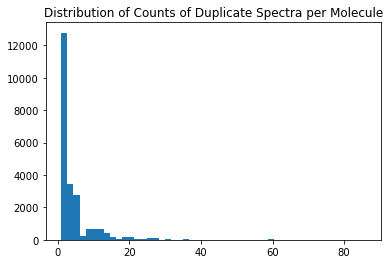

In [50]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(cn_counts, bins = 50)
ax.set_title("Distribution of Counts of Duplicate Spectra per Molecule")
fig.show()



# Filtering

In [51]:
# Checking all ID's
print("# of samples", len(data["id"]))
data["crop_id"] = [str(x)[:-4] for x in data["id"]]
id_set = set(ids)
print(ids[0], data["crop_id"][0])
included = [x for x in tqdm.tqdm(data["crop_id"]) if x in id_set]
print(f"Fraction in all_gnps: {len(included)}/{len(data['id'])}")



NameError: name 'data' is not defined

In [52]:
# global stats
global_max = 0;
gmax_index = -1;
stats = []
for idx in tqdm.tqdm(range(len(all_gnps))):
    peak = json.loads(all_gnps[idx]["peaks_json"])
    if len(peak) == 0:
        print(f"ZERO PEAK: {idx}")
        continue;
    a, b = zip(*peak)
    chemical_max = max(a)
    stats.append(len(a))
    global_max = max(global_max, chemical_max)
    if global_max == chemical_max:
        gmax_index = idx
print(f"Global Max: [{global_max}]")


  1%|          | 2616/209654 [00:13<17:58, 191.93it/s]


KeyboardInterrupt: 

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
print(max(stats))
ax.hist(stats, bins = 50)
ax.set_title("Distribution of # peaks in MS")
fig.show()

In [53]:
def bin_spectra(spectra):
    res = [0 for i in range(4973)]
    x, y = zip(*spectra)
    for i in range(len(x)):
        res[int(x[i] + 0.5)] += y[i]
    max_value = max(res)
    for i in range(len(res)):
        res[i] /= max_value
    return res
    

In [15]:
max_spec = bin_spectra(json.loads(all_gnps[gmax_index]["peaks_json"]))
print(len(max_spec))
print(np.nonzero(max_spec)[0])

4973
[ 102  111  117  120  130  148  151  159  163  164  174  178  184  190
  192  222  228  230  231  263  283  286  290  304  305  306  336  359
  421  442  449  487  491  544  550  558  635  656  660  675  719  803
  814  880  887  955  974 1011 1098 1112 1180 1281 1287 1303 1340 1367
 1416 1438 1460 1479 1520 1534 1617 1676 1758 1765 1810 1819 1891 1896
 1909 1948 1957 2049 2055 2196 2238 2282 2284 2312 2320 2361 2474 2530
 2586 2629 2690 2709 2711 2783 2808 2815 2851 2975 3027 3147 3148 3193
 3196]


In [ ]:
stats = []
for idx in tqdm.tqdm(range(len(all_gnps))):
    peak = bin_spectra(json.loads(all_gnps[idx]["peaks_json"]))
    if len(peak) == 0:
        print(f"ZERO PEAK: {idx}")
        continue;
    stats.append(len(np.nonzero(peak))[0])

fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(stats, bins = 50)
ax.set_title("Distribution of # peaks(binned) in MS")
fig.show()

In [ ]:
raw_spec = json.loads(all_gnps[0]["peaks_json"])
print("Raw_spec: ", all_gnps[0]["spectrum_id"])
raw_spec_modified = bin_spectra(raw_spec)
yiran_spec = data["mass_spec_scaled"][0]
yiran_spec = [(10 + x) / 20.0 for x in yiran_spec]
print("Yiran_spec: ", data["id"][0])
print(f"Min scaled: {min(yiran_spec)}, Max scaled: {max(yiran_spec)}")
# print(f"Min raw: {min(y)}, Max raw: {max(y)}")
# print(f"Min rawx: {min(x)}, Max rawx: {max(x)}")
pairs = []
for idx, val in enumerate(yiran_spec):
    if val != 0 and val != 20:
        pairs.append([idx, val])
pairs_raw = []
for idx, val in enumerate(raw_spec_modified):
    if val != 0:
        pairs_raw.append([idx, val])
print("len(pairs_raw)", len(pairs_raw), "len(pairs)", len(pairs))
# assert(len(pairs) == len(x))
for i in range(max(len(pairs), len(pairs_raw))):
    scal_x, scal_y = pairs_raw[i] if i < len(pairs_raw) else (-1, -1)
    true_x, true_y = pairs[i] if i < len(pairs) else (-1, -1)

    print(scal_x, true_x, scal_y, true_y, "err: ", true_y / scal_y)
print(len(raw_spec), len(yiran_spec))


# Smile Positives

In [4]:
del all_gnps

In [24]:
molid_to_idx = dict([(molid, idx) for idx, molid in enumerate(ids)])
print(len(molid_to_idx), list(molid_to_idx.items())[:5])

209654 [('CCMSLIB00000001547', 0), ('CCMSLIB00000001548', 1), ('CCMSLIB00000001549', 2), ('CCMSLIB00000001550', 3), ('CCMSLIB00000001551', 4)]


In [29]:
spectra_ids = []
spectra_id_to_smiles = {}
for key, value in cn_dict.items():
    for item in value:
        spectra_ids.append(molid_to_idx[item])
        spectra_id_to_smiles[molid_to_idx[item]] = key
print(len(spectra_ids))

99221


In [30]:
import sklearn.model_selection
X, y = spectra_ids, [1] * len(spectra_ids)
X_tr, X_va, y_tr, y_va = sklearn.model_selection.train_test_split(X, y, test_size = 0.1)

In [31]:
from collections import defaultdict

In [32]:
spectra_dict_tr = defaultdict(list)
spectra_dict_va = defaultdict(list)
for spectra in X_tr:
    spectra_dict_tr[spectra_id_to_smiles[spectra]].append(spectra)
for spectra in X_va:
    spectra_dict_va[spectra_id_to_smiles[spectra]].append(spectra)

In [34]:
cn_d = spectra_dict_tr
cn_counts = [len(cn_d[x]) for x in cn_dict]
print(f"# Unique Smiles: {len(cn_d)}, Range: [{min(cn_counts)}, {max(cn_counts)}],  \
Mean: {sum(cn_counts) / len(cn_d)} Std: {np.std(cn_counts)} Ct: {sum(cn_counts)}")

cn_d = spectra_dict_va
cn_counts = [len(cn_d[x]) for x in cn_dict]
print(f"# Unique Smiles: {len(cn_d)}, Range: [{min(cn_counts)}, {max(cn_counts)}],  \
Mean: {sum(cn_counts) / len(cn_d)} Std: {np.std(cn_counts)} Ct: {sum(cn_counts)}")

# Unique Smiles: 22780, Range: [0, 78],  Mean: 3.920017559262511 Std: 5.60413537260603 Ct: 89298
# Unique Smiles: 22780, Range: [0, 14],  Mean: 0.4356014047410009 Std: 0.8792937359797539 Ct: 9923


In [35]:
list(spectra_dict_tr.items())[:5]

[('COC1=C2CC(OC2=C(C(O)=O)C(=C1)CCC3=CC=CC=C3)C(C)(C)O',
  [17829, 17831, 17830, 22308, 22309]),
 ('CNCCC(C1=CC=CC=C1)C2=CC=CC=N2',
  [100887,
   141478,
   103994,
   142844,
   103244,
   105899,
   101289,
   145787,
   101077,
   101052,
   101184,
   142988]),
 ('CCOC(=O)OC1=C(OC)C=C(C=C1OC)C(=O)OC1CC2CN3CCC4=C(NC5=CC(OC)=CC=C45)C3CC2C(C1OC)C(=O)OC',
  [109640, 111653]),
 ('COC1=CC(CC=C)=CC(OC)=C1OC(C)C(O)C2=CC(OC)=C(OC)C(OC)=C2',
  [21020, 21019, 19144, 19143, 21018, 13965, 13964]),
 ('CC1CC2=CC(O)=C(O)C=C2C(C1C)C3=CC=C(O)C(O)=C3', [13415, 21190])]

In [36]:

with open(os.path.join("./smart_data/siamese_meta", 'spectra_map_smiles_tr.json'), 'w+') as f:
    json.dump(spectra_dict_tr, f)

with open(os.path.join("./smart_data/siamese_meta", 'spectra_map_smiles_va.json'), 'w+') as f:
    json.dump(spectra_dict_va, f)

# Saving the actual spectra

In [ ]:
ids = np.stack([np.array(all_gnps[i]["spectrum_id"]) for i in tqdm.tqdm(range(len(all_gnps)) )])
spectra = np.stack([np.array( bin_spectra(json.loads(all_gnps[i]["peaks_json"])) )for i in tqdm.tqdm(range(len(all_gnps)))])

In [19]:
# saving the data
path = "./smart_data/all_specs"
np.save(os.path.join(path, "ids"), ids)
np.save(os.path.join(path, "spectra"), spectra)


NameError: name 'spectra' is not defined

In [59]:
# for singular spec saving
path = "./smart_data/singular_specs"
ids = np.stack([np.array(all_gnps[i]["spectrum_id"]) for i in tqdm.tqdm(range(len(all_gnps)) )])
np.save(os.path.join(path, "ids"), ids)

100%|██████████| 209654/209654 [00:00<00:00, 972869.71it/s]


In [62]:
with open(os.path.join("./smart_data/siamese_meta", 'spectra_map_smiles.json'), 'w+') as f:
    json.dump(cn_dict, f)

In [ ]:
for i in tqdm.tqdm(range(len(all_gnps)) ):
    arr = np.array( bin_spectra(json.loads(all_gnps[i]["peaks_json"])) )
    spec_id = all_gnps[i]["spectrum_id"]
    np.save(os.path.join(path, spec_id), arr)

In [27]:
# mapping compounds to ids
with open('./smart_data/all_specs/spectra_map.json', 'w+') as f:
    json.dump(cn_dict, f)